# Exercise 1.2:  One Queue or Two

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [1]:
#@title
# Import libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


## Introduction

This notebook explores a question related to queueing theory, which is the study of systems that involve waiting in lines.  Who knew that was a thing, eh?

<br>

Suppose you are designing the checkout area for a new store.  There is room for two checkout counters and a waiting area for customers.  You can make two lines, one for each counter, or one line that serves both counters. In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you would have to install rope barriers, it might take up more space, and customers might be put off by what seems to be a longer line, even if it moves faster.  This figure shows the two scenarios we'll consider:

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/queues2.PNG width = 600>

So let's build a model and simulation that tests whether the single line is really better and by how much. 






### Part 1: Investigation

✅  What determines how long a line gets at a store?  Take a moment and write down a list of factors that might affect this system in a text box.  Then write a sentence or two explaining what a good starting point for a simple model might be: what assumptions can you make that would simplify the model.

### Part 2: Abstraction

The most basic model would seem to be one that looks at how often a customer arrives at the counter, and how often one leaves.  Obviously if more customers arrive than leave, there will be a line.  Let's denote the possibility of a customer arriving by using the Greek letter lambda, $\lambda$, or the variable name `lam`.  The value of $\lambda$ probably varies during the day, but let's assume it is constant.

<br>

Let's say that based on data from other stores, we know that it takes 5 minutes for a customer to check out, on average.  But checkout times are highly variable: most customers take less than 5 minutes, but some take substantially more.  So instead of just saying "each customer leaves 5 minutes after he gets to the head of the line," we can incorporate this variability by assuming that when a customer is checking out, they have the same probability of finishing up during each minute.  I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.

<br>

If we choose $\mu=1/5$, the average number of time steps for each checkout will be 5 minutes, which is consistent with the data.  Most people take less than 5 minutes, but a few take substantially longer, which is probably not a bad model of the distribution in real stores.

<br>

To ease our implementation, we'll also start by assuming there is a single checker and a single line.

### Part 3: Implementation: State and Change

Like Bikeshare, this is an initial value problem: we need a `state object` to store the state of the system, and a change function.  Start by creating a Series called `state` that serves as the state object.  `state` should stores the total number of customers in the line, including the one checking out.



In [2]:
# Define the state object
state = pd.Series(dict(cust=0),name='Customers in line')

Now write an change function that takes as parameters the following:
* `lam`
* `mu`

If there's a customer checking out, it should use `flip` to decide whether they are done.  And it should use `flip` to decide if a new customer has arrived.  It should then adjust the state object to reflect the changes.

<br>

To help you organize your code, write a commented-out statements within the function (with a '#') that explains what the code does

In [7]:
# Define change function
def change_func(lam, mu):
    # Check to see if there are any customers in line
    if state.cust > 0:
        # If there are customers in line, check to see if one leaves
        if flip(mu):
            state.cust -= 1
            
    # The addition of new custormers happens second.
    # This assumes that a newly arrived customer can not be served in 
    # the minute that s/he arrives.
    if flip(lam):
        state.cust += 1
    return

Test your function by calling it with `state.cust=1` and `lam` and `mu` equal to 0.5.  If you run it a few times, you should see different results.

In [8]:
# Test change_function
change_func(0.5,0.5)
pd.DataFrame(state)

,Customers in line
cust,1


### Part 4: Implemenation: Moving through time

In `run_simulation` for bikeshare, we moved the simulation forward using a loop:

```
    for i in range(num_steps):
        change_func(state, p1, p2)
```

In this example, `range` creates a sequence of numbers from `0` to `num_steps` (including `0` but not `num_steps`).  Each time through the loop, the next number in the sequence gets assigned to the loop variable, `i`.

<br>

Let's set up a similar loop here.  Create a version of `run_simulation` that takes `lam`, `mu`,  and `num_steps`.  Create a `Series` called `results` to save the state of the system as the loop changes the system.  When the loop is finished, plot the results.

In [19]:
def run_simulation(lam,mu,num_steps):
    """Simulate a queueing system.
    """

    results = pd.Series([],dtype=object)
    results[0] = state.cust
    
    for t in range(num_steps):
        change_func(lam,mu)
        results[t+1] = state.cust
        
    results.plot(label='customers in store',color='C3',
             title='Customers in store',xlabel='time',
             ylabel='Number of customers');
    return

Redefine the state object so that it has zero customers, and then call `run_simulation` with 60 steps in order to plot the changes to the system.

count    61.000000
mean      1.901639
std       1.044109
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       4.000000
dtype: float64


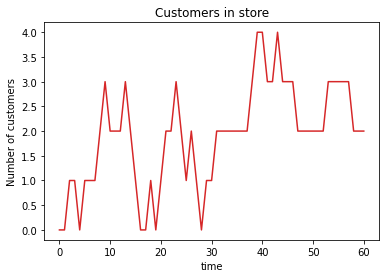

In [20]:
# Plot results
state = pd.Series(dict(cust=0),name='Customers in line')
run_simulation(0.5,0.5,60)


### Part 5: Interpretation: Defining Metrics

A plot like the one above is hard to interpret, both because it involves random changes and because the values are variable and do not necessarily show a pattern over time.

<br>

How do we define what these plots *mean*?  A chief way to do this is to define a *metric*: a quantitative value that represents the quality of the system.

✅ Take a moment and write at least two possible metrics we might use to decide the effectiveness of a queueing system. 


Now go back to `run_simulation` and find a way to print a value for one of the metrics you defined for a given situation.